# Note: Only works with python 2.5-2.7
To check compatibility, run the next cell. It will throw an error if the python version is incompatible.

If incompatible, get a different python version (I recommend anaconda environments)

In [ ]:
import sys
assert sys.version_info >= (2,5) and sys.version_info < (3,0)

### Sentiment for Dutch statements

This notebook requires Python 2 (2.5+), because it uses the [pattern](https://www.clips.uantwerpen.be/pages/pattern-nl) package. This is a text mining package for Dutch which supports sentiment analysis.

In [1]:
from pattern.nl import sentiment as sentiment_tagger
from sqlite_db_py27 import thesisDB, duplicateColumn
import json
import re
import seaborn as sns

db_file = 'D:/thesis/nl/data.db'
db = thesisDB(db_file)

settings_file = 'D:/thesis/settings - nl.json'

mean = lambda x: sum(x)/len(x)

In [18]:
#Get corpus from the DB. Only tokens.
cursor = db.getTokens(returnColumns=['lemma','docid','paragraph_no'])

corpus = []
currentDoc = 1
currentParagraph = 1
doc = []
paragraph = []

for token, docid, paragraph_no in cursor:
    if docid != currentDoc and doc: #We hit a new document!
        doc.append(paragraph)
        corpus.append((currentDoc,doc))
        paragraph = []
        doc = []
        currentDoc = docid
        currentParagraph = paragraph_no
    elif paragraph_no != currentParagraph and paragraph: #New paragraph!
        doc.append(paragraph)
        paragraph = []
        currentParagraph = paragraph_no
    paragraph.append(token)

doc.append(paragraph)
corpus.append((currentDoc,doc))

In [4]:
#Pick keywords to signal discussion of EU matters.
keywords = ['europees unie','eu','Brussel','europees parlement','europees commissie']

In [19]:
##Reconstruct the corpus to fit in the sentiment polarity tagger.
words = sorted(keywords, key = len) #Count doesn't matter, so neither does order here.
words = [r'\b'+word+r'\b' for word in words] #Append word borders so we don't match substrings
EU_words = re.compile('|'.join(words))
del words

corpus_eu = []
for docid,doc in corpus:
    newdoc = []
    for paragraph in doc:
        if re.search(EU_words,' '.join(paragraph)):
            newdoc.append(paragraph)
    corpus_eu.append((docid,newdoc))
del docid,doc,newdoc,EU_words

In [20]:
sentiment_paragraph = []
for docid,doc in corpus_eu:
    docSents = []
    for paragraph in doc:
        docSents.append(sentiment_tagger(paragraph))
    sentiment_paragraph.append((docid,docSents))
sentiment_doc = [(docid,mean([polarity for polarity, sub in doc])) for docid,doc in sentiment_paragraph if doc]

In [8]:
try:
    db.addColumn('documents',('polarity','REAL'))
except duplicateColumn:
    print("Column already exists, proceeding to fill it")
    
counter = 0
for docid,sent in sentiment_doc:
    if counter % 50 == 0:
        db.updateRow('documents',docid,{'polarity':sent})
    else:
        db.updateRow('documents',docid,{'polarity':sent}, commit = False)
db.commit()

Column already exists, proceeding to fill it


In [ ]:
try:
    db.addColumn('documents',('polarity','REAL'))
except duplicateColumn:
    print("Column already exists, proceeding to fill it")

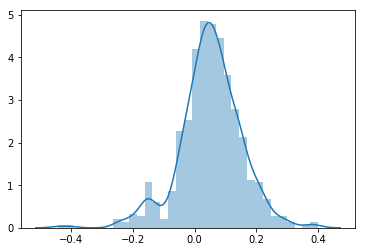

In [17]:
sns.distplot([sent for docid,sent in sentiment_doc])

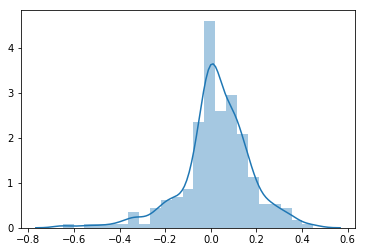

In [21]:
sns.distplot([sent for docid,sent in sentiment_doc])